In [1]:
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_default_device',jax.devices()[1])
import jax.numpy as jnp
import optax
import jax
import numpy as np
from stochastic_interpolant.neural_network import NeuralNetwork
from stochastic_interpolant.dataloaders import (
    DatasetSampler,GaussianReferenceSampler,
    OTCouplingSampler,build_trainloader,testloader_factory)
from stochastic_interpolant.loss_functions import get_linear_interpolants,root_prod_gamma,root_prod_gammadot,get_loss_functions
from stochastic_interpolant.data_generators import inf_train_gen
from stochastic_interpolant.model_training import train_model

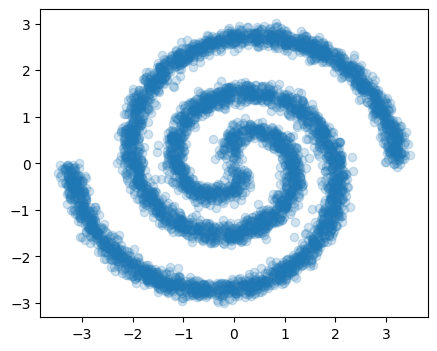

In [2]:
num_target = 5000
target_samples = inf_train_gen('2spirals',rng = 50,batch_size = num_target)
plt.figure(figsize=(5,4))
plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.2)
plt.show()

In [3]:
I,It = get_linear_interpolants()
gamma = root_prod_gamma
gammadot = root_prod_gammadot
loss_b,loss_denoise = get_loss_functions(I,It,gamma,gammadot)

b_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(21239)
)
eta_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(30238)
)

# data_coupling_sampler = IndependenceCouplingSampler(
#     GaussianReferenceSampler((2,)),
#     DatasetSampler(target_samples)
#     )
data_coupling_sampler = OTCouplingSampler(
    GaussianReferenceSampler((2,)),
    DatasetSampler(target_samples)
    )

batch_size = 1024

train_loader = build_trainloader(batch_size,jax.random.PRNGKey(124),data_coupling_sampler)
test_factory = testloader_factory(batch_size,jax.random.PRNGKey(32498130),data_coupling_sampler)

In [8]:
b_optim = optax.nadamw(4e-4) # was 4e-4

b_model,b_loss_history = train_model(
  model = b_model,
  optim = b_optim,
  steps = 10000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_b,
  print_every = 1000,
  num_testloader_batches = 100,
)


  0%|          | 0/10000 [00:00<?, ?it/s]

step=0 | train_loss=-1.1585841 | test_loss= -1.0719737
step=1000 | train_loss=-1.3466035 | test_loss= -1.3311071
step=2000 | train_loss=-1.8266037 | test_loss= -1.383895
step=3000 | train_loss=-1.5006957 | test_loss= -1.4526569
step=4000 | train_loss=-1.4523001 | test_loss= -1.4736357
step=5000 | train_loss=-1.684725 | test_loss= -1.5142976
step=6000 | train_loss=-1.6866772 | test_loss= -1.5583981
step=7000 | train_loss=-1.6643713 | test_loss= -1.5479031
step=8000 | train_loss=-1.4027734 | test_loss= -1.5841228
step=9000 | train_loss=-1.4072707 | test_loss= -1.6007397
step=9999 | train_loss=-1.5661988 | test_loss= -1.5918941


In [10]:
eta_optim = optax.nadamw(4e-4)

eta_model,eta_loss_history = train_model(
  model = eta_model,
  optim = eta_optim,
  steps = 4000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_denoise,
  print_every = 1000,
  num_testloader_batches = 100,
)

  0%|          | 0/4000 [00:00<?, ?it/s]

step=0 | train_loss=0.13033682 | test_loss= -0.2276454
step=1000 | train_loss=-0.4351122 | test_loss= -0.38958976
step=2000 | train_loss=-0.41538957 | test_loss= -0.4029056
step=3000 | train_loss=-0.3901677 | test_loss= -0.40604135
step=3999 | train_loss=-0.34986734 | test_loss= -0.4061623


In [11]:
from importlib import reload
import stochastic_interpolant.sampler as sampler

reload(sampler)
from stochastic_interpolant.sampler import StochasticSampler
from diffrax import SaveAt

stochastic_sampler = StochasticSampler(gamma,b_model,eta_model)
X0 = jax.random.normal(jax.random.PRNGKey(13334),(10000,2))
saveat = SaveAt(
    ts = jnp.linspace(0,1,50),
    dense = True
)
X1,sol = stochastic_sampler.sample_trajectory(X0,eps = 0.0,dt0 = 2e-3,saveat=saveat)

2024-05-24 17:56:07.621692: W external/xla/xla/service/hlo_rematerialization.cc:2946] Can't reduce memory use below 16.93GiB (18174179196 bytes) by rematerialization; only reduced to 17.89GiB (19212481120 bytes), down from 17.89GiB (19212481120 bytes) originally


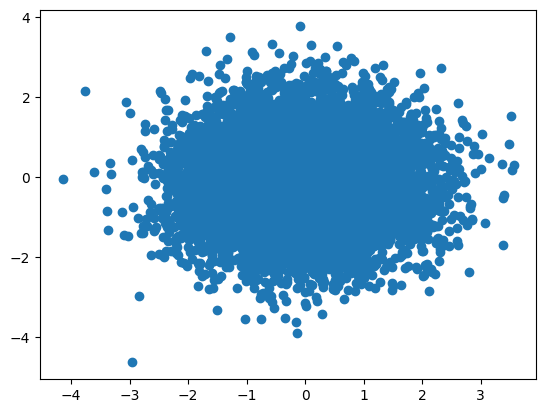

In [13]:
plt.scatter(X1[:,0],X1[:,1])

In [5]:
num_trajectories = 100

time_points = np.linspace(0,0.5,500)
plt.figure(figsize=(10,8))
plt.scatter(X1[:,0],X1[:,1],alpha = 0.05)

path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c = 'red',alpha = 0.5)

time_points = np.linspace(0.5,1.,500)
path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c='black',alpha = 0.5)

plt.scatter(X0[:num_trajectories,0],X0[:num_trajectories,1],c = 'red',s = 10.)

plt.scatter(X1[:num_trajectories,0],X1[:num_trajectories,1],c = 'blue',s = 10.)
plt.show()

NameError: name 'X1' is not defined

<Figure size 1000x800 with 0 Axes>

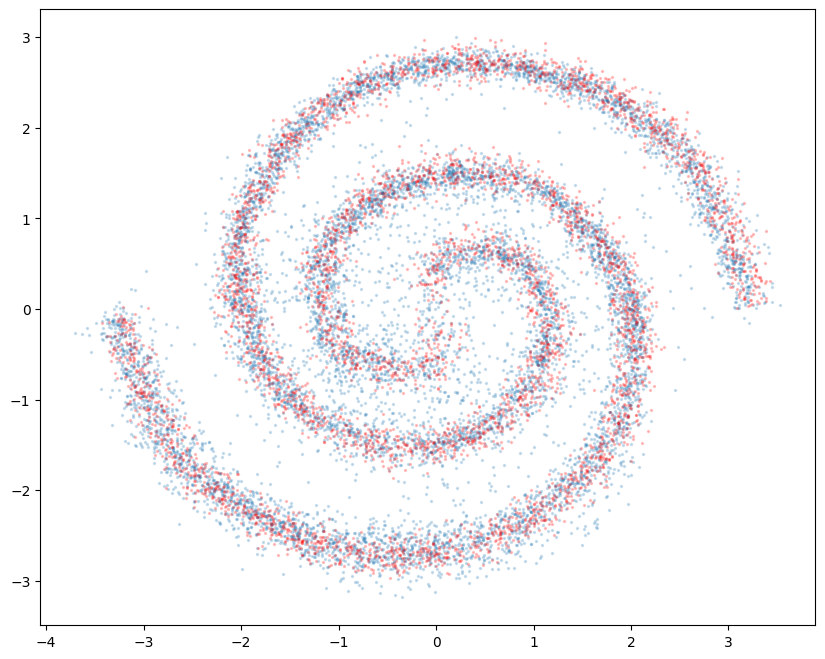

In [37]:
plt.figure(figsize=(10,8))
plt.scatter(X1[:,0],X1[:,1],alpha = 0.2, s = 2)
plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.2,c = 'red', s = 2)

In [9]:
from jax import vmap
eps = 0.01
epsilon = lambda t: t*(1-t)*eps 

vmapped_b_model = vmap(b_model)
vmapped_eta_model = vmap(eta_model)
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_b_model(jnp.hstack([t_vec,x])) - (epsilon(t)/(gamma(t)+1e-12))*vmapped_eta_model(jnp.hstack([t_vec,x]))



# t0, t1 = 0.0, 1.0
# # t_vec = jnp.ones((len(x),1))*t
# # drift = lambda t, x, args: dX_t(t,x)
# diffusion = lambda t, x, args: 2*jnp.sqrt(2*epsilon(t))
# brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jax.random.PRNGKey(1))
# terms = MultiTerm(ODETerm(dX_t), ControlTerm(diffusion, brownian_motion))
# solver = Heun()
# saveat = SaveAt(dense=True)

# sol = diffeqsolve(terms, solver, t0, t1, dt0=0.005, y0=reference_samples.copy(), saveat=saveat)
# X = sol.evaluate(1.0)
# print(X)  
X0 = jax.random.normal(jax.random.PRNGKey(13334),(10000,2))
X = X0.copy()
X_hist = []
t = 0
for i in range(100):
    X += 0.01 * dX_t(t,X,None)
    t+=0.01
    X_hist.append(X)

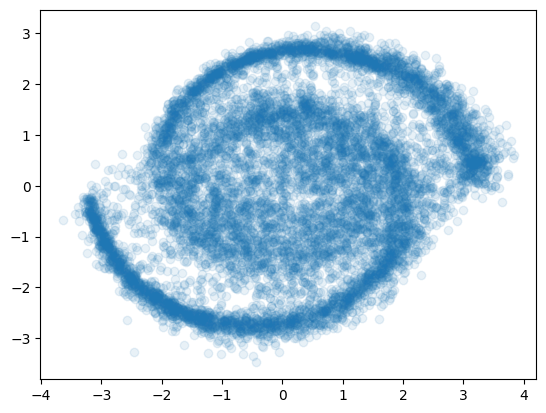

In [10]:
plt.scatter(X[:,0],X[:,1], alpha=0.1)
# plt.scatter(X0[:,0],X0[:,1], alpha=0.1)

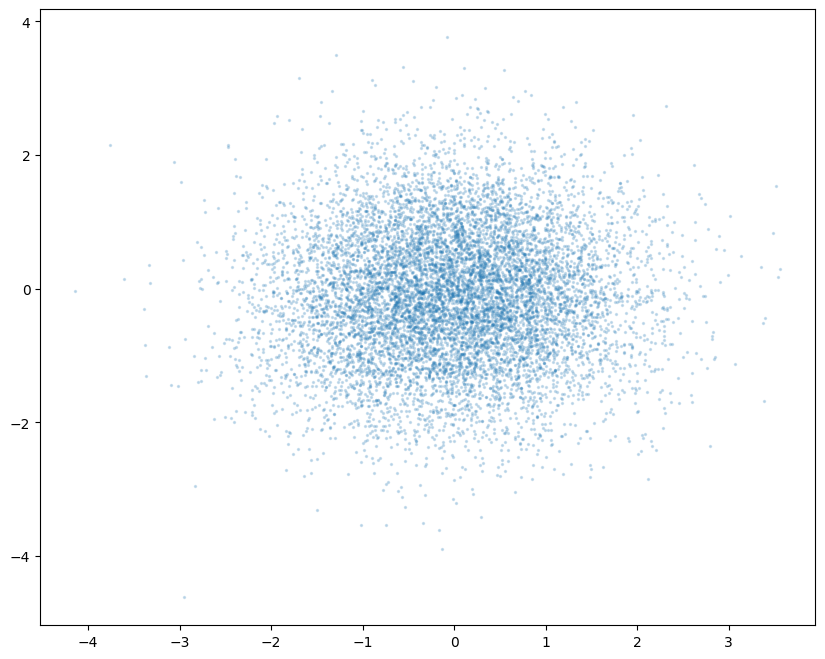

In [18]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.2, s = 2)
#plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.2,c = 'red', s = 2)

In [4]:
import jax
key = jax.random.PRNGKey(320)
jax.random.split(key,2)

Array([[ 216458715, 3952087867],
       [2022967614, 3368774614]], dtype=uint32)

In [5]:
key

Array([  0, 320], dtype=uint32)